In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use( 'seaborn-v0_8-paper')

In [2]:
!pip install crowd-kit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 1.8 MB/s eta 0:00:00


In [40]:
judge_df = pd.read_csv("ajt_judge_bm_qwen.csv")
judge_df = judge_df.rename(columns={"type_mistake": "type_mistake_human", "is_mistake": "is_mistake_human", "is_mistake_gemma": "is_mistake_gemma2",
                                    "error_type_gemma": "type_mistake_gemma2", "error_type_qwen2.5": "type_mistake_qwen2.5"})

In [41]:
judge_df['is_mistake_human'] = judge_df['is_mistake_human'].apply(lambda x: "есть ошибка" if x == 1 else "нет ошибки")
judge_df['is_mistake_gemma2'] = judge_df['is_mistake_gemma2'].apply(lambda x: "есть ошибка" if x == 1 else "нет ошибки")
judge_df['is_mistake_qwen2.5'] = judge_df['is_mistake_qwen2.5'].apply(lambda x: "есть ошибка" if x == 1 else "нет ошибки")

In [42]:
binary_judge_df = judge_df[['text', 'is_mistake_human', 'is_mistake_gemma2', 'is_mistake_qwen2.5']]
multi_judge_df = judge_df[['text', 'type_mistake_human', 'type_mistake_gemma2', 'type_mistake_qwen2.5']]

In [43]:
multi_judge_df = multi_judge_df[multi_judge_df['type_mistake_human'] != "нет ошибки"]
multi_judge_df = multi_judge_df[multi_judge_df['type_mistake_gemma2'] != "нет ошибки"]
multi_judge_df = multi_judge_df[multi_judge_df['type_mistake_qwen2.5'] != "нет ошибки"]

In [44]:
multi_judge_df = multi_judge_df.reset_index(drop=True)

In [8]:
# judge_df = judge_df[judge_df.type_mistake_gemma2 != "none"].reset_index(drop=True)
# judge_df = judge_df[judge_df['type_mistake_qwen2.5'] != "нет ошибки"].reset_index(drop=True)

# Only acceptability

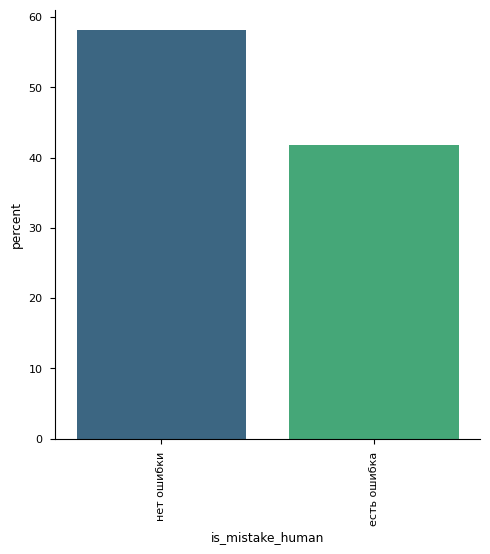

In [45]:
((binary_judge_df.groupby('is_mistake_human')['text'].count() / len(binary_judge_df) * 100).sort_values(ascending=False)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='is_mistake_human',y='percent',hue='is_mistake_human',kind='bar', palette="viridis"))
plt.xticks(rotation=90)
plt.show()

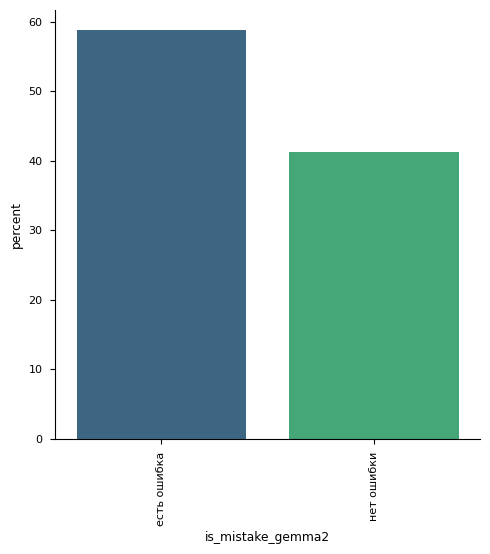

In [46]:
((binary_judge_df.groupby('is_mistake_gemma2')['text'].count() / len(binary_judge_df) * 100).sort_values(ascending=False)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='is_mistake_gemma2',y='percent', hue='is_mistake_gemma2', kind='bar', palette="viridis"))
plt.xticks(rotation=90)
plt.show()

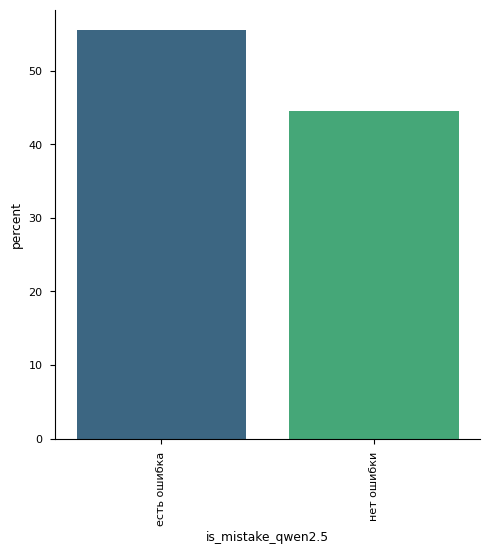

In [47]:
((binary_judge_df.groupby('is_mistake_qwen2.5')['text'].count() / len(binary_judge_df) * 100).sort_values(ascending=False)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='is_mistake_qwen2.5',y='percent', hue='is_mistake_qwen2.5', kind='bar', palette="viridis"))
plt.xticks(rotation=90)
plt.show()

In [48]:
annotators = ["human", "gemma2", "qwen2.5"]
annots = []
for v in binary_judge_df[['text', 'is_mistake_human', 'is_mistake_gemma2', 'is_mistake_qwen2.5']].values:
  txt = [v[0]]
  humans = txt + ['human'] + [v[1]]
  gemmas = txt + ['gemma2'] + [v[2]]
  qwens = txt + ['qwen2.5'] + [v[3]]
  annots.extend([humans, gemmas, qwens])

In [49]:
annot_df = pd.DataFrame(annots, columns=['text', 'annotator', 'is_mistake'])
annot_df.head()

,text,annotator,is_mistake
0,Создание новой версии Личного Кабинета МИ...,human,есть ошибка
1,Создание новой версии Личного Кабинета МИ...,gemma2,есть ошибка
2,Создание новой версии Личного Кабинета МИ...,qwen2.5,есть ошибка
3,Новая версия Кабинета должна быть развёрнута н...,human,есть ошибка
4,Новая версия Кабинета должна быть развёрнута н...,gemma2,нет ошибки


In [50]:
classes = sorted(annot_df['is_mistake'].unique())
class2id = {label: i for i, label in enumerate(classes)}

pivot = annot_df.groupby(['text', 'is_mistake']).size().unstack(fill_value=0)

for c in classes:
    if c not in pivot.columns:
        pivot[c] = 0

ratings_matrix = pivot[classes].to_numpy()

In [51]:
from statsmodels.stats.inter_rater import fleiss_kappa

kappa = fleiss_kappa(ratings_matrix)
print(f"Fleiss' Kappa: {kappa:.3f}")

Fleiss' Kappa: 0.357


In [52]:
from sklearn.metrics import cohen_kappa_score
from collections import Counter

def scotts_pi(rater1, rater2):
    assert len(rater1) == len(rater2)
    total = len(rater1)

    agree = sum(r1 == r2 for r1, r2 in zip(rater1, rater2)) / total

    counts = Counter(rater1 + rater2)
    total_ratings = 2 * total
    probs = {k: v / total_ratings for k, v in counts.items()}

    expected_agree = sum(p ** 2 for p in probs.values())
    pi = (agree - expected_agree) / (1 - expected_agree)
    return pi

In [53]:
rater1 = annot_df[annot_df.annotator == "human"]['is_mistake'].tolist()
rater2 = annot_df[annot_df.annotator == "gemma2"]['is_mistake'].tolist()
rater3 = annot_df[annot_df.annotator == "qwen2.5"]['is_mistake'].tolist()

In [54]:
kappa = cohen_kappa_score(rater1, rater2)
print(f"Cohen's Kappa Human Gemma: {kappa:.3f}")

Cohen's Kappa Human Gemma: 0.296


In [55]:
kappa = cohen_kappa_score(rater1, rater3)
print(f"Cohen's Kappa Human Qwen: {kappa:.3f}")

Cohen's Kappa Human Qwen: 0.259


In [56]:
kappa = cohen_kappa_score(rater2, rater3)
print(f"Cohen's Kappa Gemma Qwen: {kappa:.3f}")

Cohen's Kappa Gemma Qwen: 0.545


In [57]:
scottie = scotts_pi(rater1, rater2)
print(f"Scott's Pi Human Gemma: {scottie:.3f}")

Scott's Pi Human Gemma: 0.276


In [58]:
scottie = scotts_pi(rater1, rater3)
print(f"Scott's Pi Human Qwe: {scottie:.3f}")

Scott's Pi Human Qwe: 0.245


In [59]:
scottie = scotts_pi(rater2, rater3)
print(f"Scott's Pi Gemma Qwen: {scottie:.3f}")

Scott's Pi Gemma Qwen: 0.545


In [ ]:
from crowdkit.aggregation import DawidSkene, GLAD

In [ ]:
annot_df = annot_df.rename(columns={"text": "task", "annotator": "worker", "is_mistake":"label"})

In [ ]:
ds = DawidSkene()
ds_result = ds.fit_predict(annot_df)
print("Dawid-Skene:\n", ds_result)

Dawid-Skene:
 task
Создание  новой  версии  Личного  Кабинета  МИЭМ  НИУ  ВШЭ   с удобным  пользовательским  интерфейсом,  соответствующим  дизайн­коду МИЭМ НИУ ВШЭ, учитывающий все изменения в методологии ведения проектной деятельности.                      есть ошибка
Новая версия Кабинета должна быть развёрнута на тестовом сервере и к ней должен быть предоставлен публичный доступ.                                                                                                                             есть ошибка
Новая версия Кабинета должна быть развёрнута на тестовом сервере, и к ней должен быть предоставлен публичный доступ. Должен осуществляться строгий контроль за качеством кода. При разработке должны использоваться современные технологии.     есть ошибка
Кабинет  доказал  свою  эффективность  и  необходимость  для  проектной модеди обучения. Однако за 4 года использования морально устарели как дизайн Кабинета, так и его кодовая база.                                           

In [ ]:
glad = GLAD()
glad_result = glad.fit_predict(annot_df)
print("\nGLAD:\n", glad_result)


GLAD:
 task
 Bluetooth, как правило, имеет меньший радиус действия - около 20 метров, но при этом обладает меньшим энергопотреблением.                                                                          нет ошибки
 S – люди, которые могут воспринимать только конкретную информацию, или практическую, то есть информацию, которую можно потрогать, увидеть, услышать.                                              есть ошибка
 Более типичным механизмом рассеяния для криогенных температур, в котором происходит вымораживание атомов легирующей примеси, является «низкоуровневая» ударная ионизация.                          нет ошибки
 Из-за использования тяжелых моделей для запуска этой системы нужно большие вычислительные ресурсы, …                                                                                              есть ошибка
 Интерпретируемость знаний системы и быстрые алгоритмы обучения делают нечеткие нейронные сети одним из самых эффективных инструментов мягких вычислений.      

In [ ]:
print("\nАннотаторы (способности):\n", glad.alphas_)
print("\nЗадачи (трудности):\n", glad.betas_)


Аннотаторы (способности):
 worker
human      0.423691
gemma2     0.916736
qwen2.5    0.862725
Name: alpha, dtype: float64

Задачи (трудности):
 task
Создание  новой  версии  Личного  Кабинета  МИЭМ  НИУ  ВШЭ   с удобным  пользовательским  интерфейсом,  соответствующим  дизайн­коду МИЭМ НИУ ВШЭ, учитывающий все изменения в методологии ведения проектной деятельности.                      1.431979
Новая версия Кабинета должна быть развёрнута на тестовом сервере и к ней должен быть предоставлен публичный доступ.                                                                                                                             0.322926
Новая версия Кабинета должна быть развёрнута на тестовом сервере, и к ней должен быть предоставлен публичный доступ. Должен осуществляться строгий контроль за качеством кода. При разработке должны использоваться современные технологии.     0.345960
Кабинет  доказал  свою  эффективность  и  необходимость  для  проектной модеди обучения. Однако за 4 го

# Only mistakes

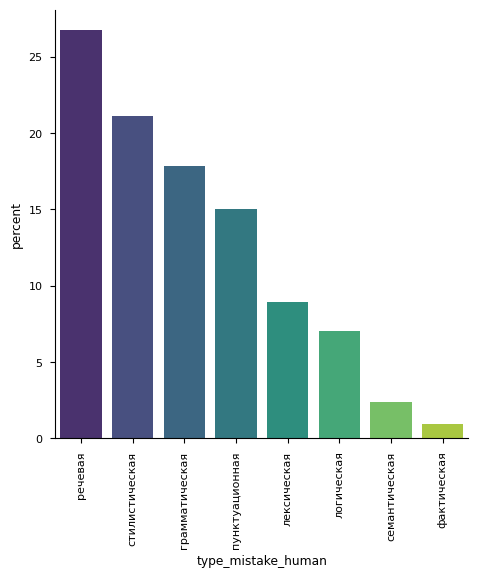

In [25]:
((multi_judge_df.groupby('type_mistake_human')['text'].count() / len(multi_judge_df) * 100).sort_values(ascending=False)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='type_mistake_human',y='percent',hue='type_mistake_human',kind='bar', palette="viridis"))
plt.xticks(rotation=90)
plt.show()

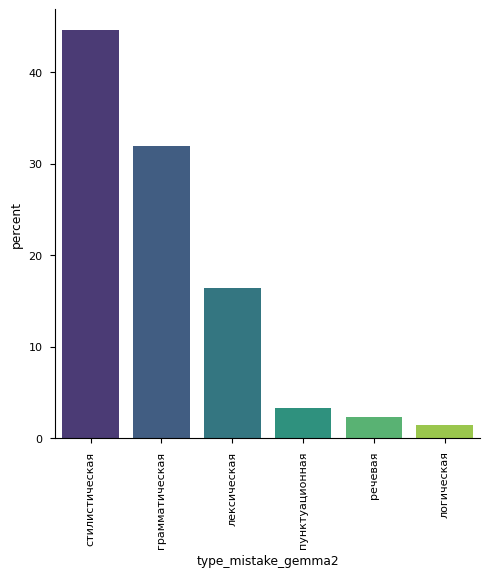

In [26]:
((multi_judge_df.groupby('type_mistake_gemma2')['text'].count() / len(multi_judge_df) * 100).sort_values(ascending=False)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='type_mistake_gemma2',y='percent',hue='type_mistake_gemma2',kind='bar', palette="viridis"))
plt.xticks(rotation=90)
plt.show()

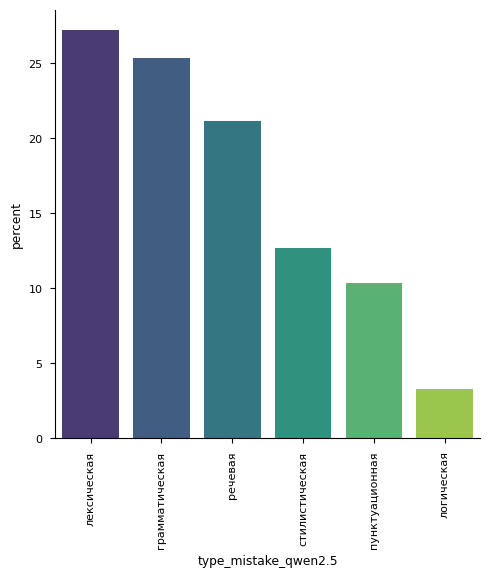

In [27]:
((multi_judge_df.groupby('type_mistake_qwen2.5')['text'].count() / len(multi_judge_df) * 100).sort_values(ascending=False)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x='type_mistake_qwen2.5',y='percent', hue='type_mistake_qwen2.5', kind='bar', palette="viridis"))
plt.xticks(rotation=90)
plt.show()

In [28]:
annotators = ["human", "gemma2", "qwen2.5"]
annots = []
for v in multi_judge_df[['text', 'type_mistake_human', 'type_mistake_gemma2', 'type_mistake_qwen2.5']].values:
  txt = [v[0]]
  humans = txt + ['human'] + [v[1]]
  gemmas = txt + ['gemma2'] + [v[2]]
  qwens = txt + ['qwen2.5'] + [v[3]]
  annots.extend([humans, gemmas, qwens])

In [29]:
annot_df = pd.DataFrame(annots, columns=['text', 'annotator', 'type_mistake'])
annot_df.head()

,text,annotator,type_mistake
0,Создание новой версии Личного Кабинета МИ...,human,грамматическая
1,Создание новой версии Личного Кабинета МИ...,gemma2,стилистическая
2,Создание новой версии Личного Кабинета МИ...,qwen2.5,стилистическая
3,Кабинет доказал свою эффективность и необ...,human,стилистическая
4,Кабинет доказал свою эффективность и необ...,gemma2,лексическая


In [30]:
classes = sorted(annot_df['type_mistake'].unique())
class2id = {label: i for i, label in enumerate(classes)}

pivot = annot_df.groupby(['text', 'type_mistake']).size().unstack(fill_value=0)

for c in classes:
    if c not in pivot.columns:
        pivot[c] = 0

ratings_matrix = pivot[classes].to_numpy()

In [31]:
from statsmodels.stats.inter_rater import fleiss_kappa

kappa = fleiss_kappa(ratings_matrix)
print(f"Fleiss' Kappa: {kappa:.3f}")

Fleiss' Kappa: 0.115


In [32]:
from sklearn.metrics import cohen_kappa_score
from collections import Counter

def scotts_pi(rater1, rater2):
    assert len(rater1) == len(rater2)
    total = len(rater1)

    agree = sum(r1 == r2 for r1, r2 in zip(rater1, rater2)) / total

    counts = Counter(rater1 + rater2)
    total_ratings = 2 * total
    probs = {k: v / total_ratings for k, v in counts.items()}

    expected_agree = sum(p ** 2 for p in probs.values())
    pi = (agree - expected_agree) / (1 - expected_agree)
    return pi

In [33]:
rater1 = annot_df[annot_df.annotator == "human"]['type_mistake'].tolist()
rater2 = annot_df[annot_df.annotator == "gemma2"]['type_mistake'].tolist()
rater3 = annot_df[annot_df.annotator == "qwen2.5"]['type_mistake'].tolist()

In [34]:
kappa = cohen_kappa_score(rater1, rater2)
print(f"Cohen's Kappa Human Gemma: {kappa:.3f}")

Cohen's Kappa Human Gemma: 0.086


In [35]:
kappa = cohen_kappa_score(rater1, rater3)
print(f"Cohen's Kappa Human Qwen: {kappa:.3f}")

Cohen's Kappa Human Qwen: 0.043


In [36]:
kappa = cohen_kappa_score(rater2, rater3)
print(f"Cohen's Kappa Gemma Qwen: {kappa:.3f}")

Cohen's Kappa Gemma Qwen: 0.286


In [37]:
scottie = scotts_pi(rater1, rater2)
print(f"Scott's Pi Human Gemma: {scottie:.3f}")

Scott's Pi Human Gemma: 0.040


In [38]:
scottie = scotts_pi(rater1, rater3)
print(f"Scott's Pi Human Qwe: {scottie:.3f}")

Scott's Pi Human Qwe: 0.028


In [39]:
scottie = scotts_pi(rater2, rater3)
print(f"Scott's Pi Gemma Qwen: {scottie:.3f}")

Scott's Pi Gemma Qwen: 0.249


In [ ]:
from crowdkit.aggregation import DawidSkene, GLAD

In [ ]:
annot_df = annot_df.rename(columns={"text": "task", "annotator": "worker", "type_mistake":"label"})

In [ ]:
ds = DawidSkene()
ds_result = ds.fit_predict(annot_df)
print("Dawid-Skene:\n", ds_result)

Dawid-Skene:
 task
Создание  новой  версии  Личного  Кабинета  МИЭМ  НИУ  ВШЭ   с удобным  пользовательским  интерфейсом,  соответствующим  дизайн­коду МИЭМ НИУ ВШЭ, учитывающий все изменения в методологии ведения проектной деятельности.                 стилистическая
Кабинет  доказал  свою  эффективность  и  необходимость  для  проектной модеди обучения. Однако за 4 года использования морально устарели как дизайн Кабинета, так и его кодовая база.                                                        лексическая
Наряду с этим относительно новый подход в образовании набирает популярность во всём мире: Проектная модель обучения.                                                                                                                       пунктуационная
Проектная модель обучения ­-  это педагогический подход, в рамках которого, ученики работают в группах, исследуют выбранный ими вопрос, используют различные ресурсы, совместно разрабатывают решения и выполняют практические задания.

In [ ]:
glad = GLAD()
glad_result = glad.fit_predict(annot_df)
print("\nGLAD:\n", glad_result)


GLAD:
 task
 S – люди, которые могут воспринимать только конкретную информацию, или практическую, то есть информацию, которую можно потрогать, увидеть, услышать.                                              стилистическая
 Из-за использования тяжелых моделей для запуска этой системы нужно большие вычислительные ресурсы, …                                                                                              грамматическая
... для выявления чувствительности растительности к ЭНЮК посредством корреляционного и вейвлет-анализа.                                                                                           стилистическая
... ключевой особенностью ... является «прогноз потерь за год» и оценка «кэшбэка от инвестиций»                                                                                                           речевая
... лекционного материала защищённого авторским правом, до работы с персональными данными сотрудников и студентов.                                 

In [ ]:
print("\nАннотаторы (способности):\n", glad.alphas_)
print("\nЗадачи (трудности):\n", glad.betas_)


Аннотаторы (способности):
 worker
human     -0.338197
gemma2     0.384589
qwen2.5    0.333930
Name: alpha, dtype: float64

Задачи (трудности):
 task
Создание  новой  версии  Личного  Кабинета  МИЭМ  НИУ  ВШЭ   с удобным  пользовательским  интерфейсом,  соответствующим  дизайн­коду МИЭМ НИУ ВШЭ, учитывающий все изменения в методологии ведения проектной деятельности.                 1.712228
Кабинет  доказал  свою  эффективность  и  необходимость  для  проектной модеди обучения. Однако за 4 года использования морально устарели как дизайн Кабинета, так и его кодовая база.                                                     1.712228
Наряду с этим относительно новый подход в образовании набирает популярность во всём мире: Проектная модель обучения.                                                                                                                       1.712228
Проектная модель обучения ­-  это педагогический подход, в рамках которого, ученики работают в группах, исследуют выбр